<a href="https://colab.research.google.com/github/nsubbaian/FrequentistML/blob/master/Project6/FML_Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMF 
NMF project is to select a dataset and use the out of the box sci-kit learn to build a recommendation system. Note, you should make sure that the dataset is appropriate for a NMF based rec system. Use your system to output some recommendations for a user or two.





In [ ]:
!pip install surprise
# load tqdm
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

     |████████████████████████████████| 11.8MB 3.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670886 sha256=504679a8338a82b537ad2c277658f9d51ab99c6c0f3d72f92f2635e315d67cc2
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
     \ 307kB 9.4MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=2836c648d7704c4eb1bd442695100685fd75611f58bacacb85888a1af760d475
  Stored in directory: /tmp/pip-ephem-wheel-cache-1e7ksthq/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
import surprise # http://surpriselib.com/
from surprise import NMF
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from collections import defaultdict
np.random.seed(42) 

# Selected Dataset: http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html 

# NMF Reccomendation system: https://www.jiristodulka.com/post/recsys_cf/

ratings_df = pd.read_csv('https://raw.githubusercontent.com/nsubbaian/FrequentistML/master/Project6/ratings.csv')
movies_df = pd.read_csv('https://raw.githubusercontent.com/nsubbaian/FrequentistML/master/Project6/movies.csv')

# Data Cleaning
# only include movies with atleast 2 ratings and users who rated atleast 5 movies
ratings_flrd_df = ratings_df.groupby("movieId").filter(lambda x: x['movieId'].count() >= 2)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= 5)

# Data Formatting for Surprise library
data = Dataset.load_from_df(ratings_flrd_df[["userId",	"movieId",	"rating"]], reader=Reader(rating_scale=(0.5, 5)) )
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
rmse_nmf = []
# from tqdm import tqdm_notebook as tqdm

for k in range(1, 25, 2):
  algo = NMF(n_factors = k)
    
  #["test_rmse"] is a numpy array with min accuracy value for each testset
  loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
  rmse_nmf.append(loss_fce)
  # print(k)


Text(0, 0.5, 'Mean RMSE')

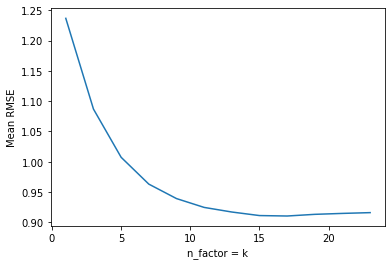

In [ ]:
plt.plot(range(1, 25, 2), rmse_nmf)
plt.xlabel("n_factor = k")
plt.ylabel("Mean RMSE")

In [ ]:
# When multiplying matrices, the dimensions of the factor matrices may be significantly lower 
# than those of the product matrix and it is this property that forms the basis of NMF. 
# NMF generates factors with significantly reduced dimensions compared to the original matrix.
param_grid = {'n_factors': [14, 16,17,18]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9119038788519622
{'n_factors': 16}


In [ ]:
algo_NMF = NMF(n_factors = 16)
algo_NMF.fit(trainset)

In [ ]:
# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo_NMF.test(testset)

In [ ]:
n = 10
userId = 1

top_n = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
    top_n[uid].append((iid, est))

for uid, user_ratings in top_n.items():
    user_ratings.sort(key = lambda x: x[1], reverse = True)
    top_n[uid] = user_ratings[: n ]

preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                    columns=["userId" ,"movieId","rat_pred"])

pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
        
hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')

In [ ]:
pred_usr.head()

,userId,movieId,rat_pred,title,genres
0,1,318,5.0,"Shawshank Redemption, The (1994)",Crime|Drama
1,1,1704,5.0,Good Will Hunting (1997),Drama|Romance
2,1,48516,5.0,"Departed, The (2006)",Crime|Drama|Thriller
3,1,58559,5.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
4,1,77455,5.0,Exit Through the Gift Shop (2010),Comedy|Documentary


In [ ]:
hist_usr.head()

,userId,movieId,rating,timestamp,title,genres
0,1,5060,5.0,964984002,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War
1,1,2872,5.0,964981680,Excalibur (1981),Adventure|Fantasy
2,1,1291,5.0,964981909,Indiana Jones and the Last Crusade (1989),Action|Adventure
3,1,1298,5.0,964984086,Pink Floyd: The Wall (1982),Drama|Musical
4,1,2948,5.0,964982191,From Russia with Love (1963),Action|Adventure|Thriller


In [ ]:
n = 10
userId = 50

top_n = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
    top_n[uid].append((iid, est))

for uid, user_ratings in top_n.items():
    user_ratings.sort(key = lambda x: x[1], reverse = True)
    top_n[uid] = user_ratings[: n ]

preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                    columns=["userId" ,"movieId","rat_pred"])

pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
        
hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')

In [ ]:
pred_usr.head()

,userId,movieId,rat_pred,title,genres
0,50,86347,3.947818,Louis C.K.: Chewed Up (2008),Comedy
1,50,177593,3.826627,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
2,50,4298,3.806723,Rififi (Du rififi chez les hommes) (1955),Crime|Film-Noir|Thriller
3,50,26810,3.798893,Bad Boy Bubby (1993),Drama
4,50,389,3.767825,"Colonel Chabert, Le (1994)",Drama|Romance|War


In [ ]:
hist_usr.head()

,userId,movieId,rating,timestamp,title,genres
0,50,924,4.5,1514238077,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
1,50,1204,4.5,1526329645,Lawrence of Arabia (1962),Adventure|Drama|War
2,50,1208,4.5,1527106159,Apocalypse Now (1979),Action|Drama|War
3,50,1251,4.5,1534178801,8 1/2 (8½) (1963),Drama|Fantasy
4,50,7327,4.0,1525359178,Persona (1966),Drama
